In [18]:
"""
In order to run the code as is, you will need scipy, pandas and tqdm installed 
(although tqdm is only needed for the progress bar, and pandas is only for the autocorrelation function)
All of these can be installed (on linux) from the command interface using 'pip'
""" 

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from gibbsrank import gibbs_sample
from eprank import eprank
import pandas
from cw2 import sorted_barplot

We first need to load the data, stored in "tennis_data.mat". The data consists of an array, $W$ containing the names of each player, and an array, G, containing the results of all of the matches in the season. 

In [19]:
# set seed for reproducibility
np.random.seed(0)
# load data
data = sio.loadmat('tennis_data.mat')
# Array containing the names of each player
W = data['W']
# loop over array to format more nicely
for i, player in enumerate(W):
    W[i] = player[0]
# Array of size num_games x 2. The first entry in each row is the winner of game i, the second is the loser
G = data['G'] - 1
# Number of players
M = W.shape[0]
# Number of Games
N = G.shape[0]

In [20]:
player = "Rui-Machado"
print(np.where(W == player)[0])

[74]


# Gibbs sampling (This may take a minute)

In [21]:
# number of iterations
num_iters = 1100
# perform gibbs sampling, skill samples is an num_players x num_samples array
skill_samples = gibbs_sample(G, M, num_iters)#, random_nums)


100%|██████████| 1100/1100 [01:27<00:00, 12.55it/s]


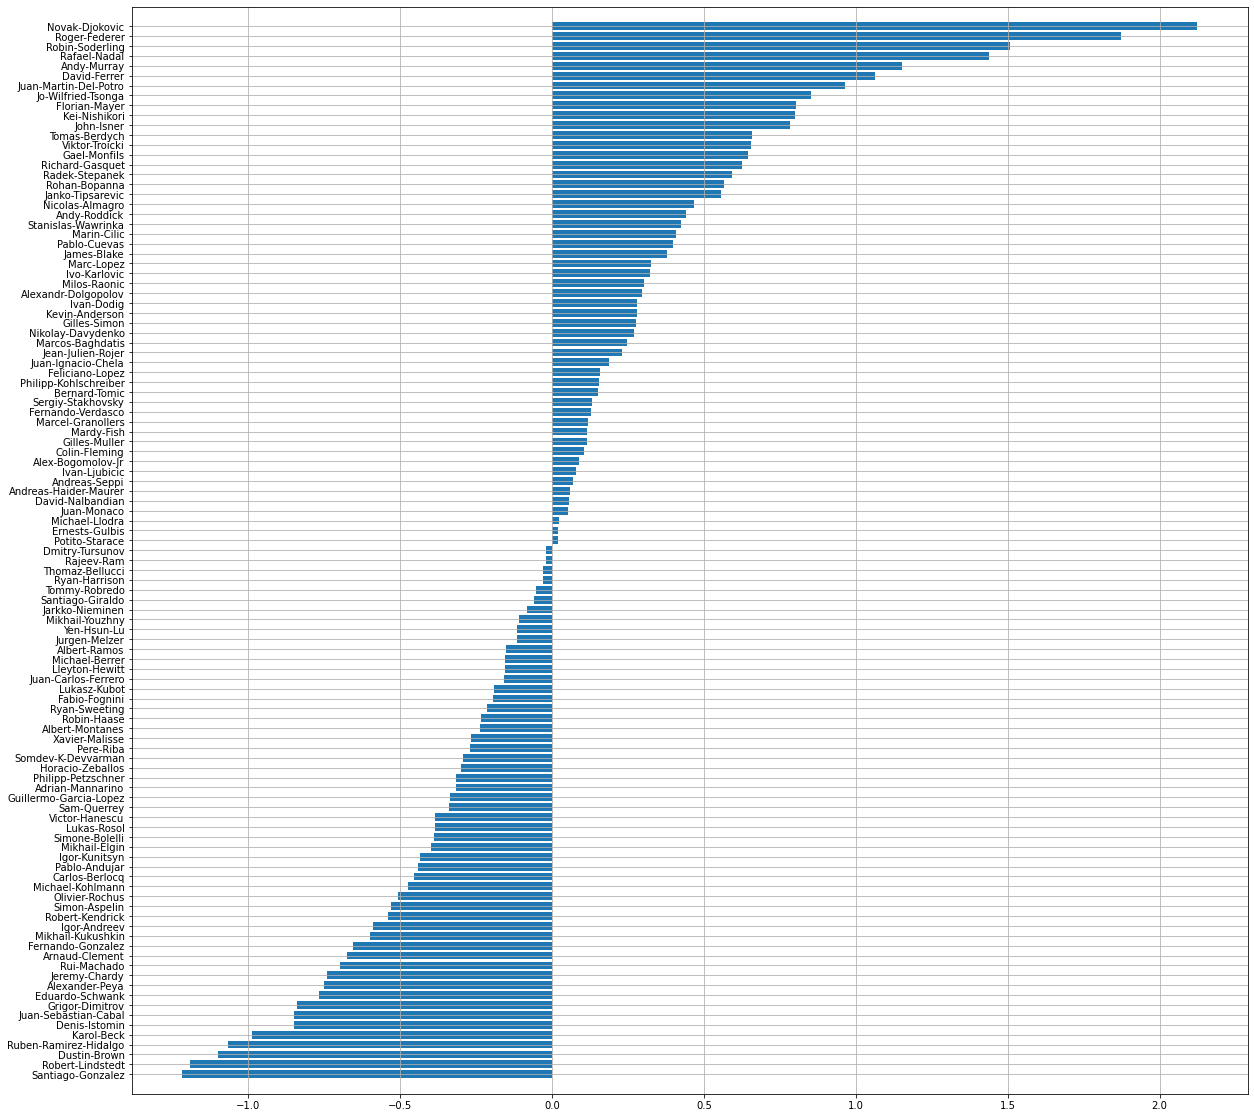

In [23]:
sorted_barplot(skill_samples[:,200], W)

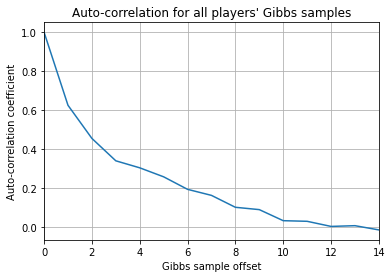

In [48]:
# Code for plotting the autocorrelation function for player p
n=15
p_arr = np.array(range(0, M))
p_arr = [15]

for p in p_arr:
    autocor = np.zeros(n)
    for i in range(n):
        autocor[i]=pandas.Series.autocorr(pandas.Series(skill_samples[p,:]),lag=i)
    plt.plot(autocor)
#plt.legend(W[p_arr][:,0])
plt.title("Auto-correlation for all players' Gibbs samples")
plt.ylabel("Auto-correlation coefficient")
plt.xlabel("Gibbs sample offset")
plt.xlim(0,14)
plt.grid()

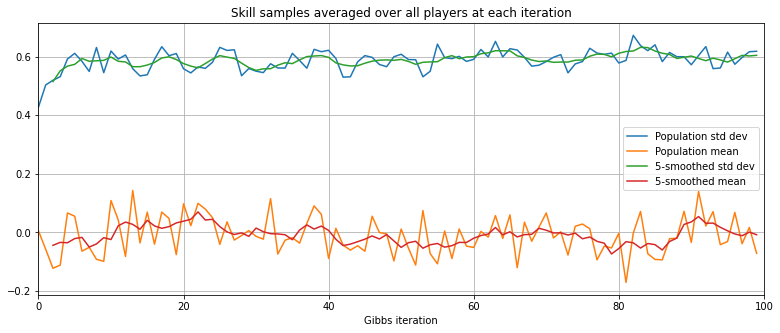

In [41]:
window = 5
num_points = 100
iteration_mean = np.mean(skill_samples, axis=0)
iteration_std = np.std(skill_samples, axis=0)

rolling_mean=pandas.DataFrame(iteration_mean).rolling(window=window, center=True)
rolling_std=pandas.DataFrame(iteration_std).rolling(window=window, center=True)

plt.figure(figsize=(13,5))
plt.title("Skill samples averaged over all players at each iteration")
plt.plot(iteration_std[0 : num_points])
plt.plot(iteration_mean[0: num_points])

plt.plot(rolling_std.mean()[0 : num_points])
plt.plot(rolling_mean.mean()[0 : num_points])
plt.xlabel("Gibbs iteration")
plt.legend(["Population std dev", "Population mean", "{}-smoothed std dev".format(window), "{}-smoothed mean".format(window)])
plt.xlim(0, num_points)
plt.grid()

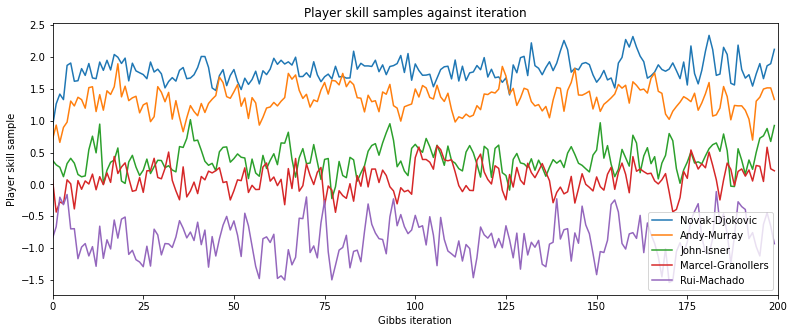

In [31]:
top_four = [15, 0, 10, 4]
p_arr = [15, 10, 20, 45, 74]
num_points = 200
plt.figure(figsize=(13,5))
for p in p_arr:
    plt.plot(skill_samples[p,0:num_points])

plt.xlim(0, num_points)
plt.title("Player skill samples against iteration")
plt.xlabel("Gibbs iteration")
plt.ylabel("Player skill sample")
plt.legend(W[p_arr][:,0])

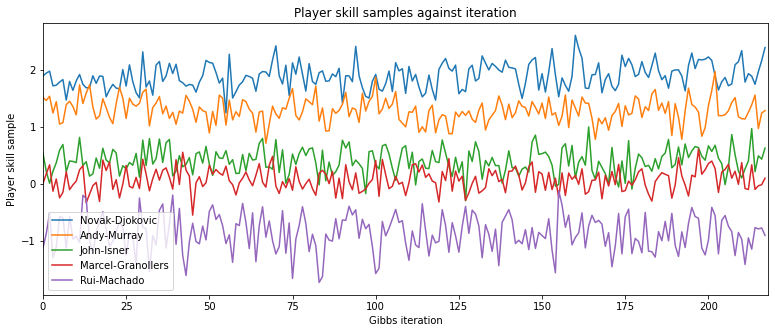

In [42]:
p_arr = [15, 10, 20, 45, 74]
burn_in = 10
thinning = 5
num_iters=1100

indices = np.array(range(burn_in, num_iters, thinning))
num_points = len(indices)

plt.figure(figsize=(13,5))
for p in p_arr:
    plt.plot(skill_samples[p,indices])

plt.xlim(0, num_points)
plt.title("Player skill samples against iteration")
plt.xlabel("Sample index")
plt.ylabel("Player skill sample")
plt.legend(W[p_arr][:,0])

# EP ranking

In [9]:
num_iters = 3
# run message passing algorithm, returns mean and precision for each player
mean_player_skills, precision_player_skills = eprank(G, M, num_iters)

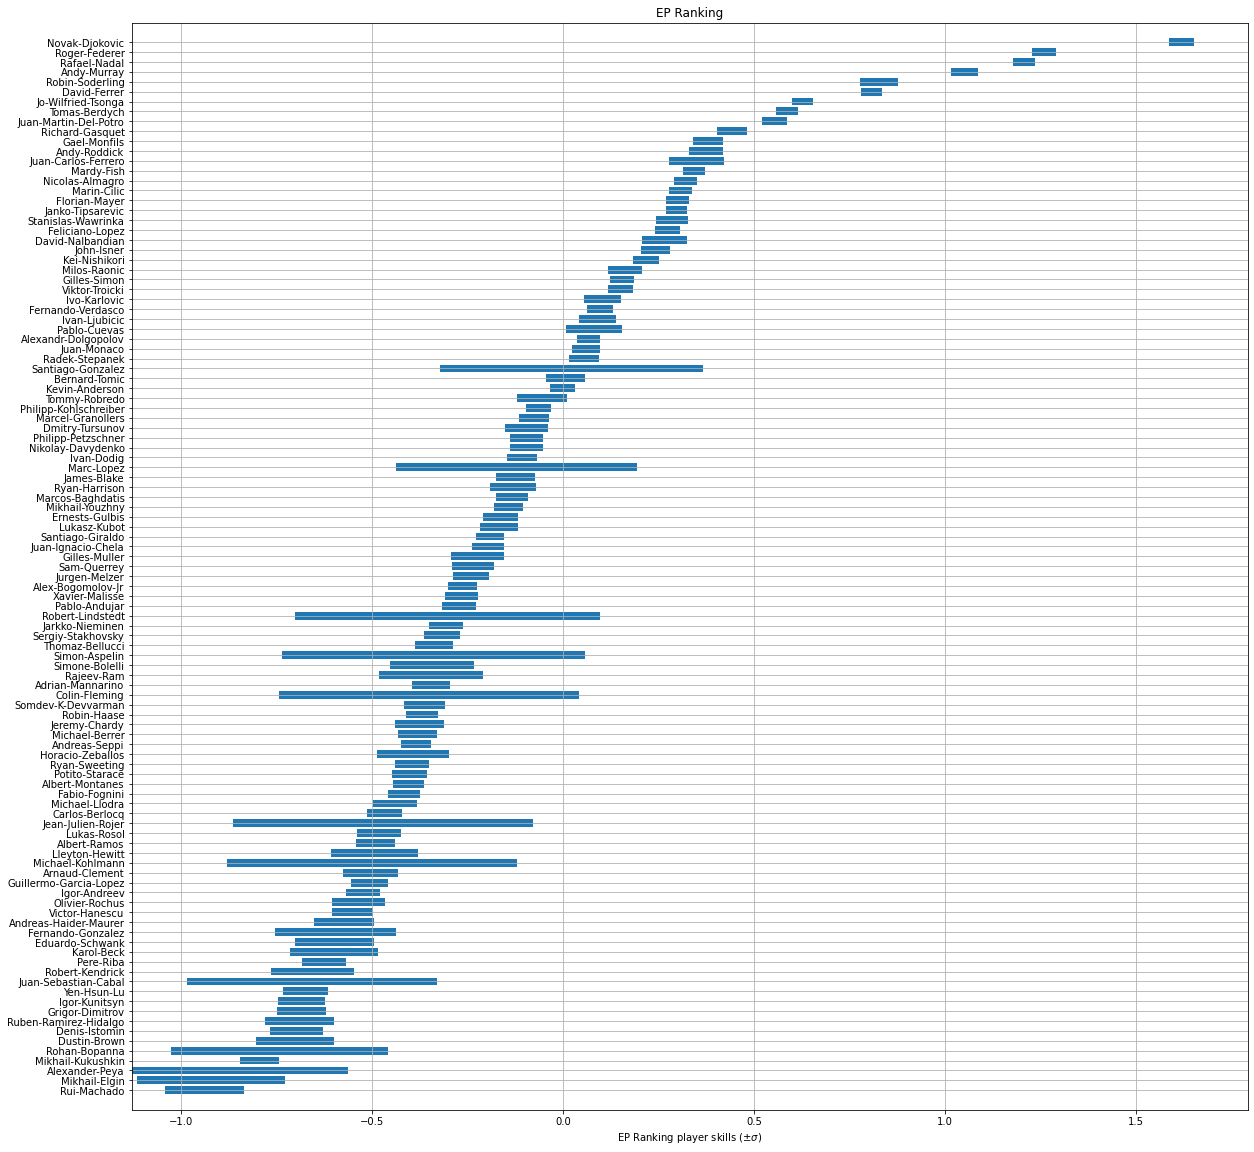

In [10]:
def sorted_rangeplot(mean, std_dev, W, xlabel="Placeholder", title="Placeholder"):
    M = len(mean)
    xx = np.linspace(0, M, M)
    plt.figure(figsize=(20, 20))
    sorted_indices = np.argsort(mean)
    sorted_names = W[sorted_indices]
    width = 2 * std_dev
    left = mean - std_dev
    plt.barh(xx, width=width[sorted_indices], left=left[sorted_indices])
    plt.yticks(np.linspace(0, M, M), labels=sorted_names[:, 0])
    plt.ylim([-2, 109])
    plt.xlabel(xlabel)
    plt.title(title)
    plt.grid()
    

std_dev = np.true_divide(1, precision_player_skills)
sorted_rangeplot(mean_player_skills, std_dev, W, xlabel="EP Ranking player skills ($\pm \sigma$)", title="EP Ranking")

In [65]:
n = 13
p_arr = [15, 10, 20, 45, 74, 69, 55]
P = len(p_arr)

selected_player_means = np.zeros((n, P))
selected_player_precs = np.zeros((n, P))

for i in range(0, n):
    mean_player_skills, precision_player_skills = eprank(G, M, i)
    selected_player_means[i, :] = mean_player_skills[p_arr]
    selected_player_precs[i, :] = precision_player_skills[p_arr]

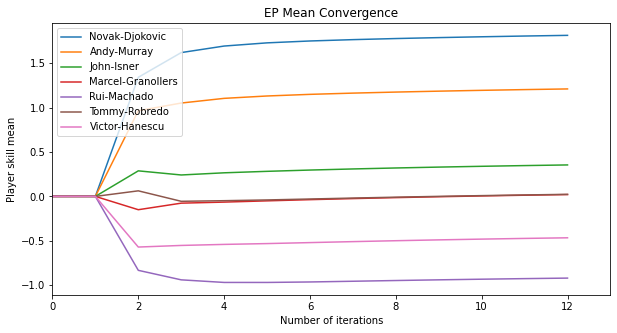

In [66]:
plt.figure(figsize=(10,5))
for p in range(0, P):
    plt.plot(selected_player_means[:, p])
plt.title("EP Mean Convergence")
plt.xlim(0, n)
plt.xlabel("Number of iterations")
plt.ylabel("Player skill mean")
plt.legend(W[p_arr][:,0])

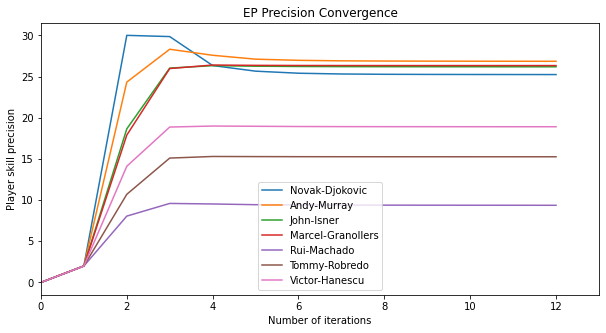

In [67]:

plt.figure(figsize=(10,5))
for p in range(0, P):
    plt.plot(selected_player_precs[:, p])
plt.title("EP Precision Convergence")
plt.xlim(0, n)
plt.xlabel("Number of iterations")
plt.ylabel("Player skill precision")
plt.legend(W[p_arr][:,0])

# Nadal v Djokovic

In [178]:
djokovic = 15
nadal = 0

top_four = [15, 10]

burn_in = 10
num_iters = 1100
thinning = 5

indices = np.array(range(burn_in, num_iters, thinning))

djokovic_samples = skill_samples[djokovic, indices]
nadal_samples = skill_samples[nadal, indices]



['Novak-Djokovic'] has mu=1.899029968277427, sigma=0.22410970606651648
['Rafael-Nadal'] has mu=1.4630204094405852, sigma=0.18751342380788627


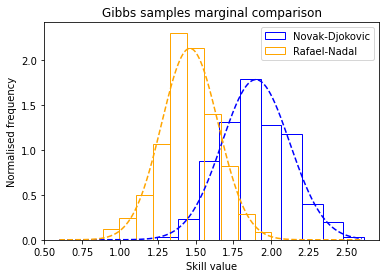

In [179]:
from scipy.stats import norm


def plot_hist_with_overlay(values, player, color):
    x = np.linspace(0.6, 2.6, 1000)
    (mu, sigma) = norm.fit(values)
    print("{} has mu={}, sigma={}".format(player, mu, sigma))
    fit = norm.pdf(x, mu, sigma)

    plt.hist(values, density=True, label=player, edgecolor=color, fill=False)
    plt.plot(x, fit, color=color, linestyle="--")

plot_hist_with_overlay(djokovic_samples, W[djokovic], "blue")
plot_hist_with_overlay(nadal_samples, W[nadal], "orange")
plt.title("Gibbs samples marginal comparison")
plt.xlabel("Skill value")
plt.ylabel("Normalised frequency")
plt.legend()



[1.4630204094405852, 1.899029968277427]
[[0.03532332 0.00805283]
 [0.00805283 0.05045661]]


Text(0.5, 1.0, 'Gibbs samples with 2-D Gaussian approximation')

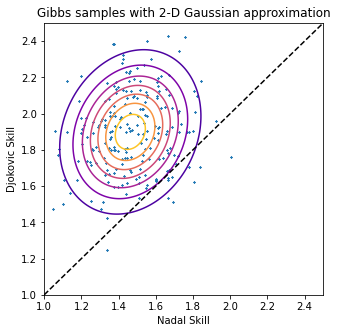

In [180]:
from scipy.stats import multivariate_normal

#nadal_samples = skill_samples[10, indices] # switch to Murray

mean_vector = [np.mean(nadal_samples), np.mean(djokovic_samples)]
cov_matrix = np.cov(nadal_samples, djokovic_samples)

print(mean_vector)
print(cov_matrix)

lower = 1
upper= 2.5
x, y = np.mgrid[lower:upper:.01, lower:upper:.01]
pos = np.dstack((x, y))
rv = multivariate_normal(mean=mean_vector, cov=cov_matrix)
fig = plt.figure(figsize=((5,5)))
ax = fig.add_subplot(111)
cs = ax.contour(x, y, rv.pdf(pos), cmap="plasma")
ax.scatter(nadal_samples, djokovic_samples, marker="x", s=2)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle="--", color="black")
plt.xlim(lower, upper)
plt.ylim(lower, upper)

plt.xlabel("Nadal Skill")
plt.ylabel("Djokovic Skill")
plt.title("Gibbs samples with 2-D Gaussian approximation")


Diff has mu=0.43600955883684167, sigma=0.2633527372388316


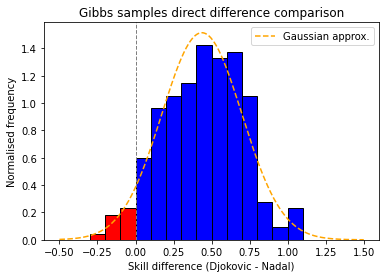

In [181]:
values = djokovic_samples - nadal_samples

bins = np.linspace(-0.5, 1.5, 21)
x = np.linspace(-0.5, 1.5, 1000)

(mu, sigma) = norm.fit(values)
print("Diff has mu={}, sigma={}".format(mu, sigma))
fit = norm.pdf(x, mu, sigma)

_, _, bars= plt.hist(values, bins=bins, density=True, edgecolor="black", color="blue")
plt.plot(x, fit, linestyle="--", label="Gaussian approx.", color="orange")
plt.axvline(x=0, linestyle='--',linewidth=1, color='grey')

for bar in bars:
    if bar.get_x() < 0:
        bar.set_facecolor("red") 

plt.title("Gibbs samples direct difference comparison")
plt.xlabel("Skill difference (Djokovic - Nadal)")
plt.ylabel("Normalised frequency")
plt.legend()

In [172]:
from scipy.stats import norm

top_four = [15, 4, 0, 10]

burn_in = 10
num_iters = 1100
thinning = 5

indices = np.array(range(burn_in, num_iters, thinning))

selected_samples = np.zeros((4, len(indices)))

for idx, p in enumerate(top_four):
    selected_samples[idx] = skill_samples[p, indices]

prob_better_player = np.zeros((4, 4))
print(W[top_four])
for i in range(0, 4):
    for j in range(0, 4):

        skill_diff = np.mean(selected_samples[i] - selected_samples[j])
        var = np.sum(np.cov(selected_samples[i], -selected_samples[j]))
        prob_better_player[i, j] = norm.cdf(skill_diff / np.sqrt(var))

print(prob_better_player)


[['Novak-Djokovic']
 ['Roger-Federer']
 ['Rafael-Nadal']
 ['Andy-Murray']]
[[       nan 0.92429949 0.95071324 0.97638777]
 [0.07570051        nan 0.62716426 0.81361731]
 [0.04928676 0.37283574        nan 0.74747275]
 [0.02361223 0.18638269 0.25252725        nan]]


# Method comparison
1. Empirical game outcome averages
2. Gibbs sampling predictions
3. Message passing predictions

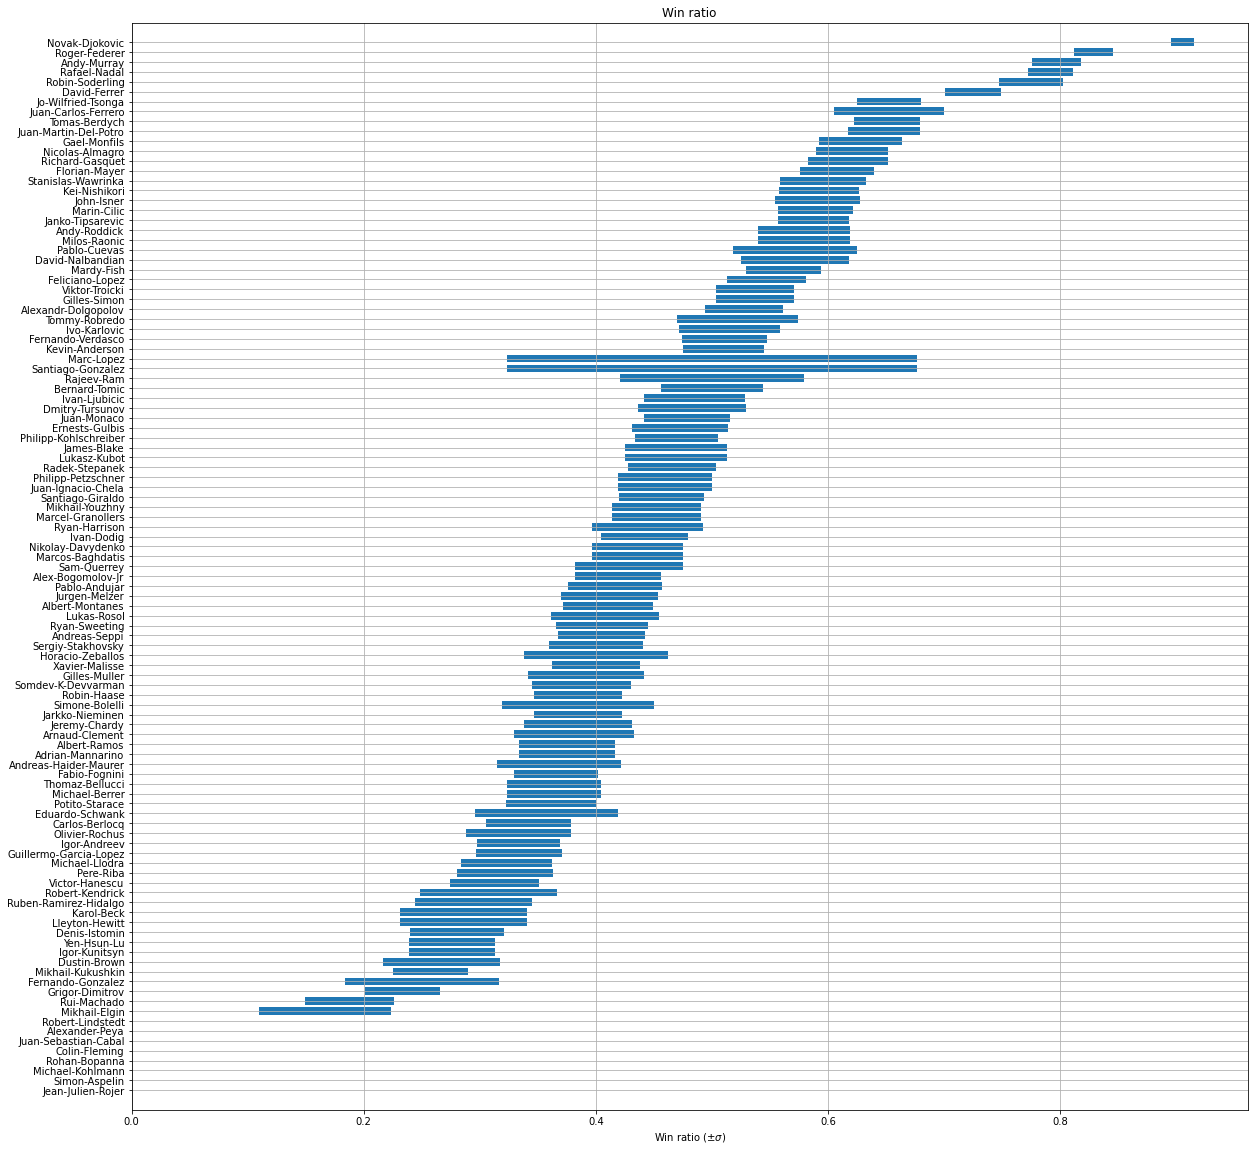

In [193]:
points = np.zeros(M)
matches = np.zeros(M)

for p in range(0, M):
    for g in range(0, N):
        if G[g, 0] == p:
            points[p] += 1
            matches[p] += 1
        elif G[g, 1] == p:
            matches[p] += 1

win_ratio = np.true_divide(points, matches)
var = np.multiply(win_ratio, 1 - win_ratio)
win_std = np.true_divide(var, np.sqrt(matches))
sorted_rangeplot(win_ratio, win_std, W, xlabel="Win ratio ($\pm \sigma$)", title="Win ratio")

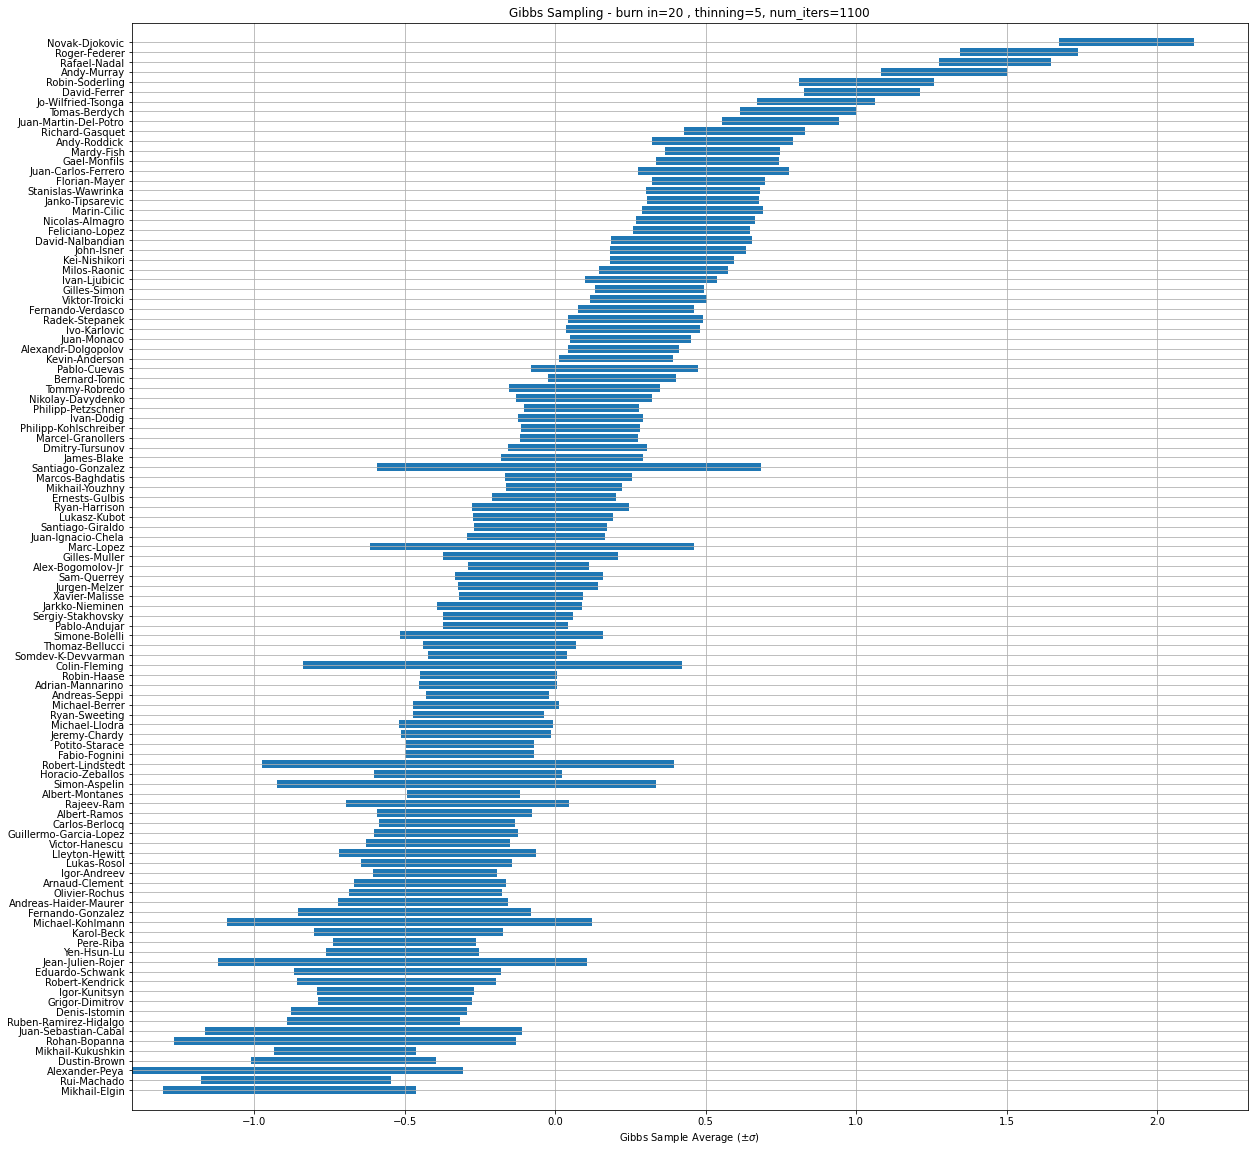

In [194]:
burn_in = 20
thinning = 5
num_iters=1100

indices = np.array(range(burn_in, num_iters, thinning))
relevant_samples = skill_samples[:, indices]

gibbs_means = np.mean(relevant_samples, axis=1)
gibbs_std = np.std(relevant_samples, axis=1)

sorted_rangeplot(gibbs_means, gibbs_std, W, xlabel="Gibbs Sample Average ($\pm \sigma$)", title="Gibbs Sampling - burn in={} , thinning={}, num_iters={}".format(burn_in, thinning, num_iters))

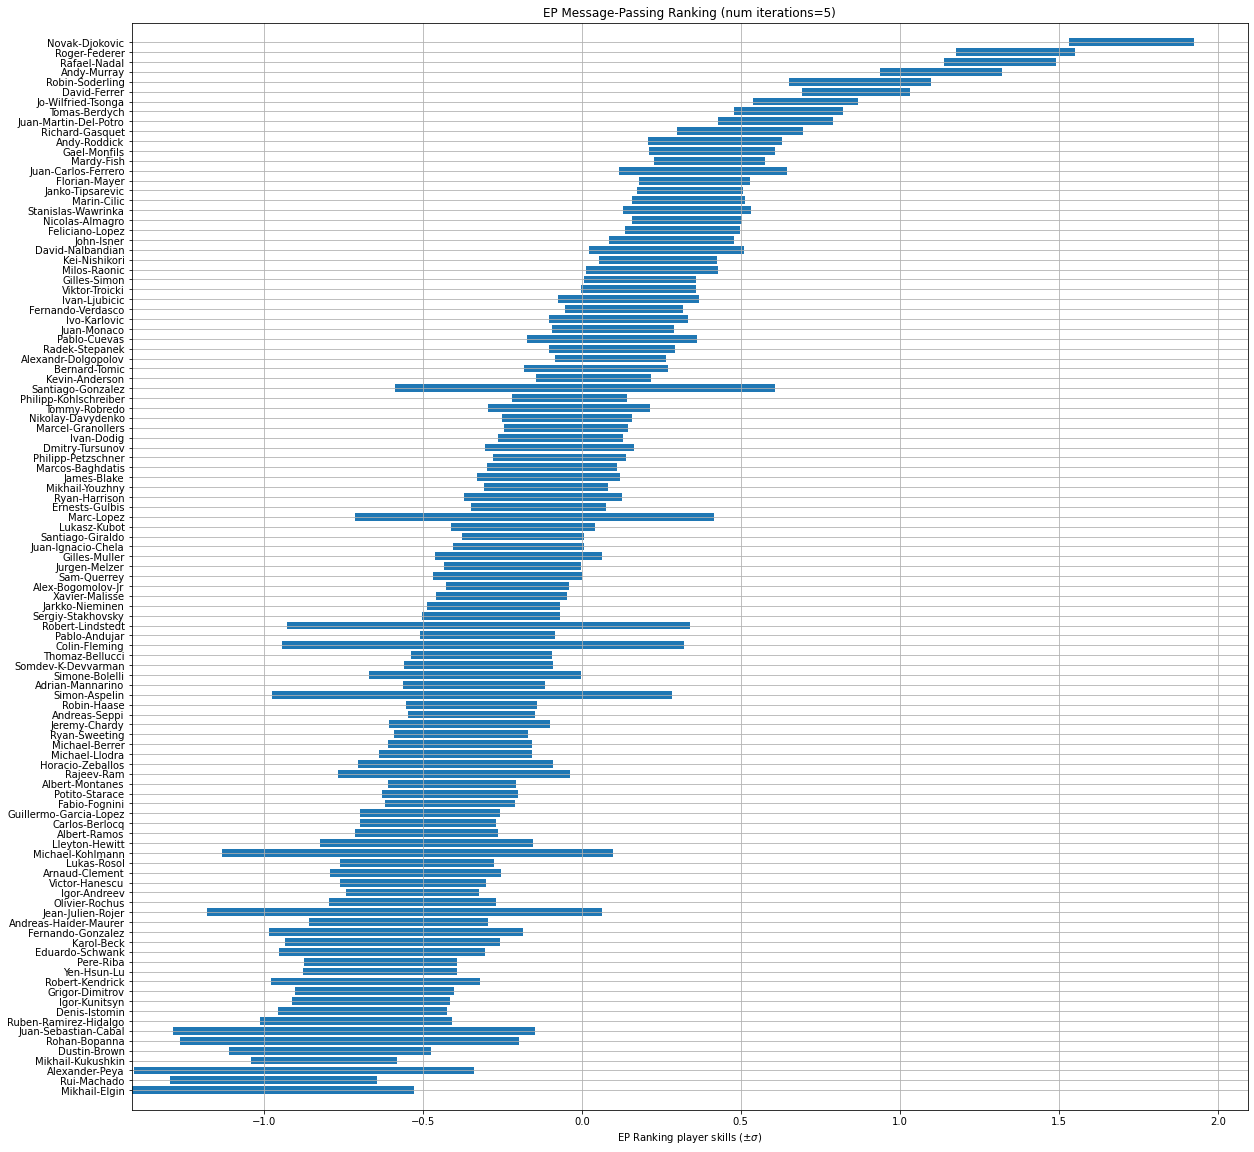

In [195]:
num_iters = 5
# run message passing algorithm, returns mean and precision for each player
ep_means, precision_player_skills = eprank(G, M, num_iters)

ep_std = np.sqrt(np.true_divide(1, precision_player_skills))
sorted_rangeplot(ep_means, ep_std, W, xlabel="EP Ranking player skills ($\pm \sigma$)", title="EP Message-Passing Ranking (num iterations={})".format(num_iters))

In [196]:
from scipy.stats import spearmanr

win_rankings = np.argsort(win_ratio)
gibbs_rankings = np.argsort(gibbs_means)
ep_rankings = np.argsort(ep_means)

print(gibbs_rankings)
print(ep_rankings)

print(spearmanr(win_rankings, gibbs_rankings))
print(spearmanr(win_rankings, ep_rankings))
print(spearmanr(ep_rankings, gibbs_rankings))

[104  74  96  88  51 101  97  85  66  53  67  87  58 106  80  84  38 102
  82  91  36  93  77  94  70  55   6  50  72  95  90 103  56 105  43  73
  92  27  18  83  48  60  59  98  34  89  49  21  54  30  75  76  63  81
  13 100  78   9  86  71  39  52  26  99  65  61  45  68  17  64  40  69
  37  57  62  32   1  35  19  16  79  41  22   8  31  20  12  24  42  25
  47  46   7  44  28   3  14  11   2  33   5  29  23  10   0   4  15]
[104  74  96  51  88 101  97  85  66  67  53  87  80  84  58  38  82  91
 106  36  77  55  93  94 102  70  72  50   6  43  73  90  95  56  27  83
  18  92  48  59 103  60  49  34  89  98  21 105  54  30  75  81  63  76
  13  78   9  86 100  39  71  52  65  26  64  61  17  45  40  69  68  99
  62  37  32  19  57   1  35  16  22  79  41   8  31  12  20  24  42  46
  25  47   7  44   3  28  14  11   2  33   5  29  23  10   0   4  15]
SpearmanrResult(correlation=0.5394992064891554, pvalue=2.0227872456334692e-09)
SpearmanrResult(correlation=0.42723211661670485, pv

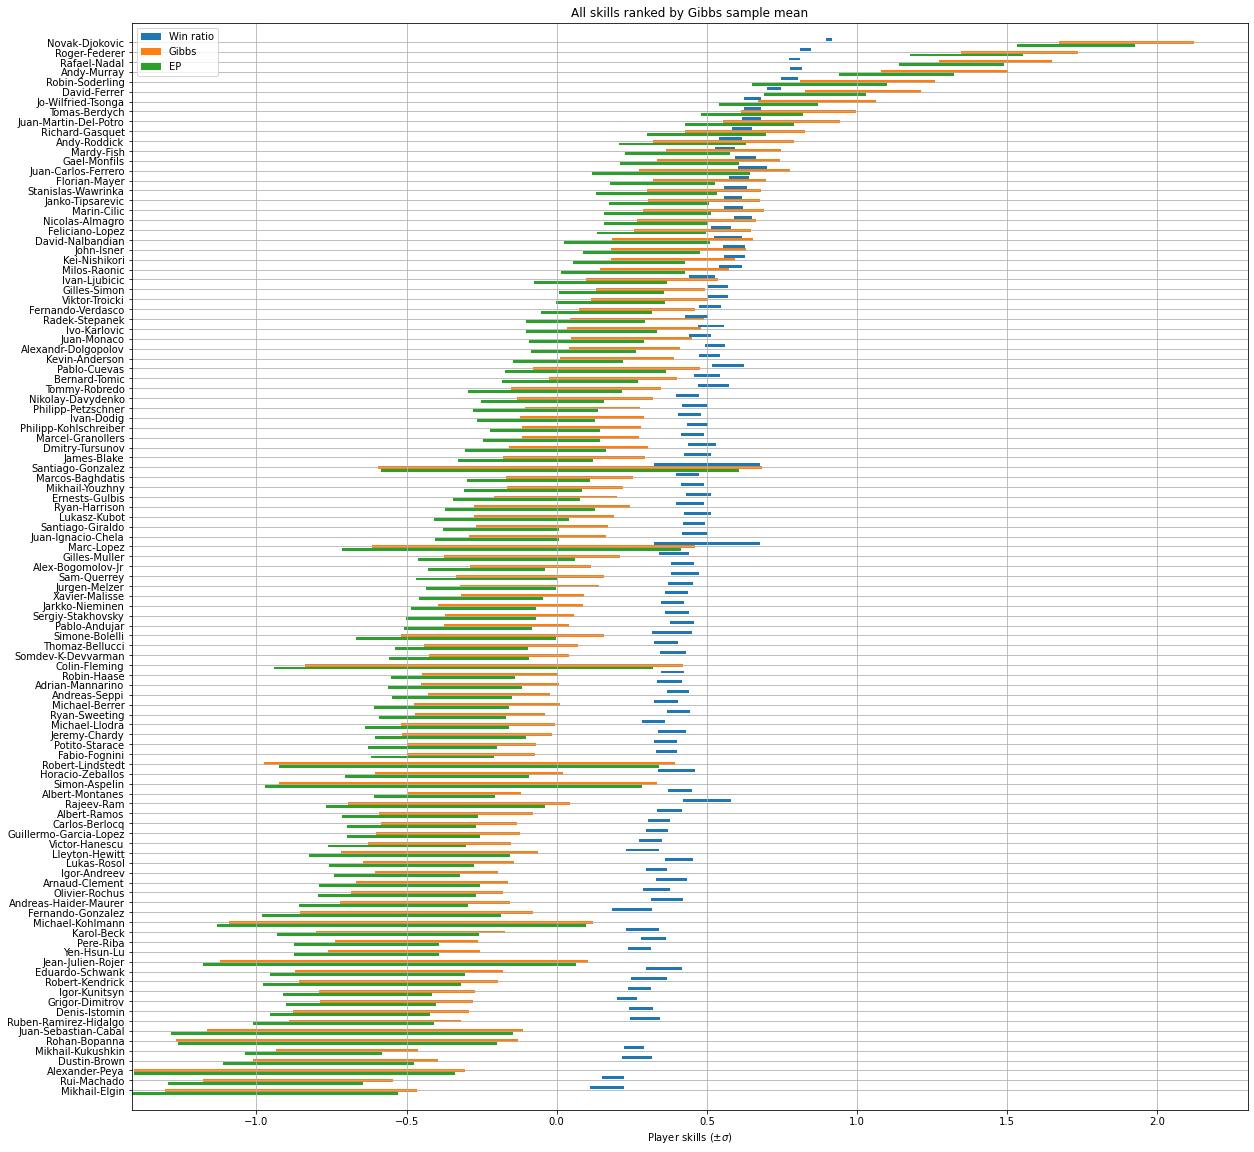

In [203]:
    mean = mean_player_skills
    std_dev = std_dev
    
    M = len(mean)
    xx = np.linspace(0, M, M)
    plt.figure(figsize=(20, 20))
    gibbs_rankings = np.argsort(gibbs_means)
    sorted_names = W[gibbs_rankings]
    plt.barh(xx+0.3, height=0.3, width=2*gibbs_std[gibbs_rankings], left=gibbs_means[gibbs_rankings] - gibbs_std[gibbs_rankings], label="Gibbs")
    plt.barh(xx, height=0.3, width=2*win_std[gibbs_rankings], left=win_ratio[gibbs_rankings]-win_std[gibbs_rankings], label="Win ratio")
    plt.barh(xx-0.3, height=0.3, width=2*ep_std[gibbs_rankings], left=ep_means[gibbs_rankings]-ep_std[gibbs_rankings], label="EP")
    plt.yticks(xx, labels=sorted_names[:, 0])
    plt.ylim([-2, 109])
    plt.xlabel("Player skills ($\pm \sigma$)")
    plt.title("All skills ranked by Gibbs sample mean")
    plt.legend()
    plt.grid()